# Simple Linear Model on Cat vs Dog
Dataset
DeepNet Dojo
San Wong (hswong1@uci.edu)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import cv2 as cv
import random
import pandas as pd
import seaborn as sns
import os

from IPython.display import display, Image, HTML

In [2]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using TensorFlow backend.


## Load Cat vs Dog Data (Step 1: Create ImagePath Array)

In [3]:
# Define Training/Testing Data Path
TRAIN_DIR = '../../data/CatvsDog/train/'
TEST_DIR = '../../data/CatvsDog/test/'

# Create an array of Training Image Path / Testing Image Path
train_imagePath = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR)]
test_imagePath = [TEST_DIR + i for i in os.listdir(TEST_DIR)]

# Create an array of Traingin Dog image
train_dog_imagePath = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cat_imagePath = [TRAIN_DIR + i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

# Define Parameter
ROW = 150
COL = 150
IMAGE_SIZE = 150
CHANNELS = 3
pixel_depth = 255.0

# DownSize Training and Validation Size (For some case where RAM is limited)
Train_Val_Dog_Size = 1000
Train_Val_Cat_Size = 1000
Train_Val_All_Size = 2000

Train_Size = 1600
Val_Size = 400
Test_All_Size = 500

if (Train_Size + Val_Size != Train_Val_All_Size):
    print("ERROR: Sum of Train and Val dataset doesn't match")
    exit()

Train_imagePath_Downsized = train_dog_imagePath[:Train_Val_Dog_Size] + train_cat_imagePath[:Train_Val_Cat_Size]
Train_labels_Downsized = np.array((['dogs']*Train_Val_Dog_Size)+(['cats']*Train_Val_Cat_Size))
Test_imagePath_Downsized = test_imagePath[:Test_All_Size]
Test_labels_Downsized = np.array (['unknownclass'] * Test_All_Size)

## Utility Functions

In [4]:
# TO UNDERSTAND cv.imread
test_img = cv.imread("../../data/CatvsDog/train/dog.8011.jpg",cv.IMREAD_COLOR)
print(type(test_img))
print(test_img.shape)

<class 'numpy.ndarray'>
(500, 380, 3)


In [5]:
'''
# Read Image
def read_image(imagePath):
    img = cv.imread(imagePath, cv.IMREAD_COLOR)
    return cv.resize(img, (ROW, COL), interpolation=cv.INTER_CUBIC)
'''

def read_image(imagePath):
    img=cv.imread(imagePath,cv.IMREAD_COLOR)
    '''
    if type(img) is np.ndarray:
        print("img: nparray")
    else:
        print("img: not nparray")
    '''
    #Height >= Width
    #Resize image while keeping the aspect ratio: 
    if(img.shape[0]>=img.shape[1]):
        resizeto = (IMAGE_SIZE, int(round(IMAGE_SIZE*(float(img.shape[1])/img.shape[0]))))
    else:
        resizeto = (int(round(IMAGE_SIZE*(float(img.shape[0])/img.shape[1]))),IMAGE_SIZE)
    
    img2 = cv.resize(img, (resizeto[1], resizeto[0]), interpolation=cv.INTER_CUBIC)
    img3 = cv.copyMakeBorder(img2, 0, IMAGE_SIZE - img2.shape[0], 0, IMAGE_SIZE - img2.shape[1], cv.BORDER_CONSTANT, 0)
    
    return img3[:,:,::-1]
    
            

# Create 4 Dimension Array to hold every Pixel Values for RGB Channel for Each Images
def create_NormalizedPixelValue_array(imagePath):
    numOfImage = len(imagePath)
    # Create an initial 4 dimension array (in unsigned int data type)
    data = np.ndarray((numOfImage, ROW, COL, CHANNELS),dtype=np.float32)
    
    # Fill up the data Array
    for i, image_file in enumerate(imagePath):
        #print("i: {0}".format(i))
        #print("image_file: {0}".format(image_file))
        image = read_image(image_file)
        #Normalized Image
        image_data = np.array(image,dtype=np.float32)
        # For R Channel
        image_data[:,:,0] = (image_data[:,:,0].astype(float)) / pixel_depth
        # For G Channel
        image_data[:,:,1] = (image_data[:,:,1].astype(float))/ pixel_depth
        # For B Channel
        image_data[:,:,2] = (image_data[:,:,2].astype(float)) / pixel_depth
        #The following shows how to transform image dimensions
        #print(image_data.shape)
        data[i] = image_data
    return data

## Create Image_NormalizedPixelValue_Array for training and testing images

In [6]:
train_image_NormalizedPixelValue_array = create_NormalizedPixelValue_array(Train_imagePath_Downsized)
test_image_NormalizedPixelValue_array = create_NormalizedPixelValue_array(Test_imagePath_Downsized)

print("Train image array shape: {}".format(train_image_NormalizedPixelValue_array.shape))
print("Test image array shape: {}".format(test_image_NormalizedPixelValue_array.shape))

Train image array shape: (2000, 150, 150, 3)
Test image array shape: (500, 150, 150, 3)


## Display Normalized Images (Value between 0 to 1)

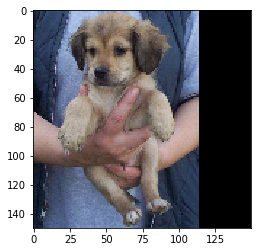

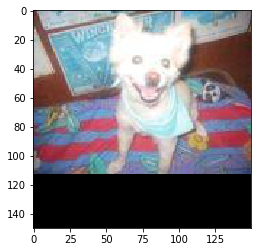

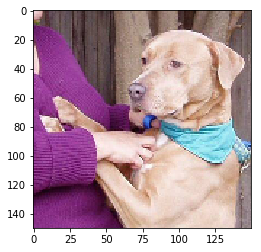

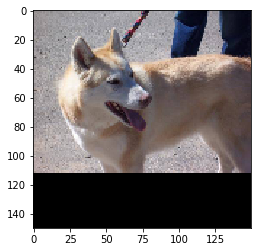

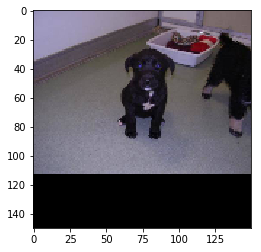

In [7]:
# Display first 5 images
plt.imshow(train_image_NormalizedPixelValue_array[0,:,:,:],interpolation='nearest')
plt.figure ()
plt.imshow(train_image_NormalizedPixelValue_array[1,:,:,:],interpolation='nearest')
plt.figure ()
plt.imshow(train_image_NormalizedPixelValue_array[2,:,:,:],interpolation='nearest')
plt.figure ()
plt.imshow(train_image_NormalizedPixelValue_array[3,:,:,:],interpolation='nearest')
plt.figure ()
plt.imshow(train_image_NormalizedPixelValue_array[4,:,:,:],interpolation='nearest')
plt.figure ()

## Randomize

In [8]:
np.random.seed(133)
def randomize(dataset, labels):
    # labels.shape[0] should give you number of training data
    #print("labels.shape[0]: {0}".format(labels.shape[0]))
    permutation = np.random.permutation(labels.shape[0])
    #print("permutation: {0}".format(permutation))
    shuffled_dataset = dataset[permutation,:,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels    

In [9]:
## Create Randomized Training Dataset (image and label)
train_dataset_rand, train_labels_rand = randomize(train_image_NormalizedPixelValue_array,Train_labels_Downsized)
test_dataset_rand, test_labels_rand = randomize(test_image_NormalizedPixelValue_array,Test_labels_Downsized)

## Split Training and Validate (Val_Size = 400; Train_Size = 1600)
valid_dataset = train_dataset_rand[:Val_Size,:,:,:]
valid_labels = train_labels_rand[:Val_Size]
train_dataset = train_dataset_rand[Val_Size:Val_Size+Train_Size,:,:,:]
train_labels = train_labels_rand[Val_Size:Val_Size+Train_Size]

print("Training: ", train_dataset.shape, train_labels.shape)
print("Validation: ", valid_dataset.shape, valid_labels.shape)
print("Test: ", test_image_NormalizedPixelValue_array.shape, Test_labels_Downsized.shape)


Training:  (1600, 150, 150, 3) (1600,)
Validation:  (400, 150, 150, 3) (400,)
Test:  (500, 150, 150, 3) (500,)


## One-Hot Encoding

In [11]:
# Origial Labels
train_labels[0:5]

array(['cats', 'dogs', 'cats', 'dogs', 'cats'], dtype='<U4')

In [12]:
num_labels = 2
'''
# What's already been defined:
ROW = 150
COL = 150
IMAGE_SIZE = 150
CHANNELS = 3
pixel_depth = 255.0

# DownSize Training and Validation Size (For some case where RAM is limited)
Train_Val_Dog_Size = 1000
Train_Val_Cat_Size = 1000
Train_Val_All_Size = 2000

Train_Size = 1600
Val_Size = 400
Test_All_Size = 500

Reference Code: (Maynot be very scable)
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (labels=='cats').astype(np.float32); # set dogs to 0 and cats to 1
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

Therefore, we will write our own function to create one-hot label


Label_Dict = ['cats','dogs'] => label_vec : [train/test/val_size, 2]



'''
# For example: train_labels is with shape (1600,)
# Comment: The "reformat" provided by the reference Kaggle Post will work here, but not really scalable
def reformat(labels, labels_dic):
    # Get size of labels
    labels_vec_len = labels.shape[0]
    labels_dic_len = len(labels_dic)
    
    # Example: dict = {'cats':0,'dogs':1,'birds':2}
    # define Zero_matrix of "labels_vec"
    labels_vec = np.zeros((labels_vec_len,labels_dic_len), dtype=np.int)
    for i in range(labels_vec_len):
        current_label = labels[i]
        # Get Key value from dict
        index = labels_dic[current_label]
        labels_vec[i,index] = 1
    
    
    return labels_vec

#train_dataset, train_labels = reformat(train_dataset, train_labels)

In [19]:
# Test "reformat" function
labels_dic = {'cats':0,'dogs':1}
train_labels_vec = reformat(train_labels, labels_dic)
print("Size of train_labels: {0}".format(train_labels_vec.shape))
# Show first 5 labels
print("Print First 5 label in One-Hot style")
train_labels_vec[0:5]

Size of train_labels: (1600, 2)
Print First 5 label in One-Hot style


array([[1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0]])

In [20]:
# Perform the same for Validation Set
val_labels_vec = reformat(valid_labels, labels_dic)

## Define Model (Linear Model)

Tensorflow
(1) Placeholder variables used to change the input to the graph.
(2) Model variables that are going to be optimized so as to make the model perform better.
(3) Model, which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
(4) A cost measure that can be used to guide the optimization of the variables.
(5) An optimization method which updates the variables of the model.

## Define Placeholder 

In [21]:
img_size_flat = ROW*COL
num_classes = 2

x = tf.placeholder(tf.float32, [None, img_size_flat])
# y_true is a vector that carries the label
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

In [22]:
weights = tf.Variable(tf.zeros([img_size_flat,num_classes]))

In [23]:
biases = tf.Variable(tf.zeros([num_classes]))

In [24]:
logits = tf.matmul(x,weights) + biases

In [25]:
y_pred = tf.nn.softmax(logits)

The predicted class is calculated from the y_pred matrix and takes the index of the largest element in each row

In [26]:
y_pred_cls = tf.argmax(y_pred, axis = 1)

## Define Cost-Function

The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. Therefore, the goal is to minimize the Cross-Entrop

In [27]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [28]:
cost = tf.reduce_mean(cross_entropy)

## Define Optimizer

In [29]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)

In [30]:
correct_pred = tf.equal(y_pred_cls, y_true_cls)

In [31]:
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

## Create Tensorflow Session

In [32]:
session = tf.Session()

In [33]:
session.run(tf.global_variables_initializer())

In [34]:
batch_size = 100

Define optimize function. This is the function that run the session for num_iterations and feed in data

In [ ]:
# Define next_batch function
def next_batch():
    retrun x_batch, y_true_batch

In [26]:
def optimize (num_iterations):
    for i in range(num_iterations):
        # Get a new batch
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Define data feed dictionary
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        session.run(optimizer, feed_dict = feed_dict_train)

In [27]:
feed_dict_test = {x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls}

In [28]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict = feed_dict_test)
    print("Accuracy on Test-Set: {0:.1%}".format(acc))

In [29]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [30]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_pred, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

We don't usually plot weight coz there are a lot of parameters in a network. However, in this simply network, we can visualize each weight and see what they detect in images

In [31]:
def plot_weights():
    # Recall that weights = tf.Variable(tf.zeros([img_size_flat,num_classes]))
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    

In [32]:
print_accuracy()

Accuracy on Test-Set: 9.8%


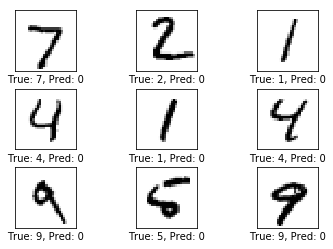

In [33]:
plot_example_errors()

## Run for 10 Iterations

In [34]:
optimize(num_iterations=9)

In [35]:
print_accuracy()

Accuracy on Test-Set: 73.4%


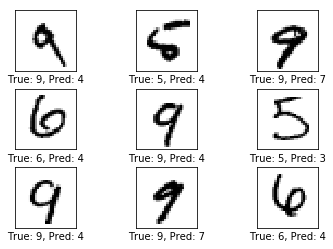

In [36]:
plot_example_errors()

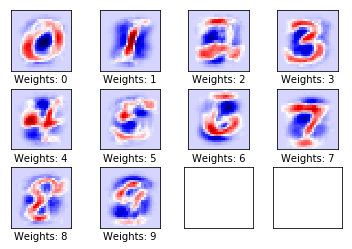

In [37]:
plot_weights()

## Run for 1000 Iterations

In [38]:
optimize(num_iterations=990)


In [39]:
print_accuracy()

Accuracy on Test-Set: 91.9%


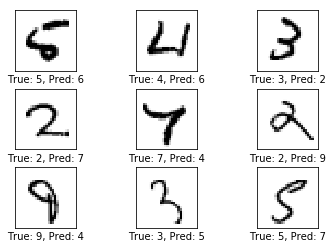

In [40]:
plot_example_errors()

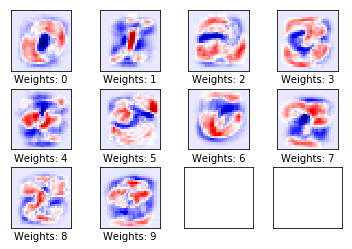

In [41]:
plot_weights()

[[ 961    0    3    2    0    2    9    1    2    0]
 [   0 1095    3    3    0    1    4    2   27    0]
 [  11    3  923   10    9    2   14   12   42    6]
 [   3    0   28  906    0   23    3   17   24    6]
 [   1    1    4    1  911    0   15    3   11   35]
 [  11    3    5   38    9  747   18   10   44    7]
 [  13    3    5    1    9    8  913    2    4    0]
 [   3    5   23    5    5    1    0  960    4   22]
 [  10    3    7   17    9   20   13   13  877    5]
 [  11    4    2    9   32    6    0   31   13  901]]


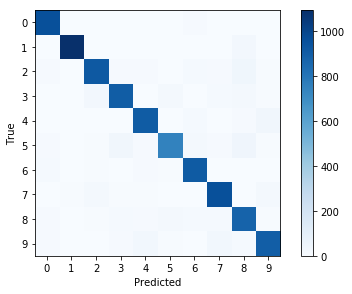

In [42]:
print_confusion_matrix()